<a href="https://colab.research.google.com/github/Shaunak-Mukherjee/ECE570-Artificial-Intelligence/blob/main/ECE570_F2024_Assignment_03_Exercise_Shaunak_Mukherjee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 57000 Assignment 3 Exercise

Your Name: Shaunak Mukherjee

Prepare the pacakge we will use.

In [ ]:
import time
from typing import List, Dict
from tqdm import tqdm
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Exercise 0: Train your model on GPU (0 points)

Some tasks in this assignment can take a long time if you run it on the CPU. For example, based on our solution of Exercise 3 Task 4 (Transfer Learning: finetuning of a pretrained model (resnet18)), it will take roughly 2 hours to train the model end-to-end (complete model and not only the last fc layer) for 1 epoch on CPU. Hence, we highly recommend you try to train your model on GPU.

To do so, first you need to enable GPU on Colab (this will restart the runtime). Click `Runtime`-> `Change runtime type` and select the `Hardware accelerator` there.  You can then run the following code to see if the GPU is correctly initialized and available.

**Note**: If you would like to avoid GPU overages on Colab, we would suggest writing and debugging your code before switching on the GPU runtime. Otherwise, the time you spent debugging code will likely count against your GPU usage. Once you have the code running, you can switch on the GPU runtime and train the model much faster.

In [ ]:
print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')

Can I can use GPU now? -- True


### You must manually move your model and data to the GPU (and sometimes back to the cpu)
After setting the GPU up on colab, then you should put your **model** and **data** to GPU. We give a simple example below. You can use `to` function for this task. See [torch.Tensor.to](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to move a tensor to the GPU (probably your mini-batch of data in each iteration) or [torch.nn.Module.to](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.to) to move your NN model to GPU (assuming you create subclass [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)). Note that `to()` of tensor returns a NEW tensor while `to` of a NN model will apply this in-place. To be safe, the best semantics are `obj = obj.to(device)`. For printing, you will need to move a tensor back to the CPU via the `cpu()` function.

Once the model and input data are on the GPU, everything else can be done the same.  This is the beauty of PyTorch GPU acceleration.  None of the other code needs to be altered.

To summarize, you need to 1) enable GPU acceleration in Colab, 2) put the model on the GPU, and 3) put the input data (i.e., the batch of samples) onto the GPU using `to()` after it is loaded by the data loaders (usually you only put one batch of data on the GPU at a time).

In [ ]:
rand_tensor = torch.rand(5,2)
simple_model = nn.Sequential(nn.Linear(2,10), nn.ReLU(), nn.Linear(10,1))
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

# device = torch.device('cuda')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ----------- <Your code> ---------------
# Move rand_tensor and model onto the GPU device

rand_tensor = rand_tensor.to(device)
simple_model = simple_model.to(device)

# --------- <End your code> -------------
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

input is on cpu
model parameters are on [device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]
output is on cpu
input is on cuda:0
model parameters are on [device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0)]
output is on cuda:0


## Exercise 1: Why use a CNN rather than only fully connected layers? (40 points)

In this exercise, you will build two models for the **MNIST** dataset: one uses only fully connected layers and another uses a standard CNN layout (convolution layers everywhere except the last layer is fully connected layer). Note, you will need to use cross entropy loss as your objective function. The two models should be built with roughly the same accuracy performance, your task is to compare the number of network parameters (a huge number of parameters can affect training/testing time, memory requirements, overfitting, etc.).

### Task 1: Prepare train and test function

We will create our train and test procedure in these two functions. The train function should apply one epoch of training. The functions inputs should take everything we need for training and testing and return some logs.

#### Arguments requirement:
* For the `train` function, it takes the `model`, `loss_fn`, `optimizer`, `train_loader`, and `epoch` as arguments.
    * `model`: the classifier, or deep neural network, should be an instance of `nn.Module`.
    * `loss_fn`: the loss function instance. For example, `nn.CrossEntropy()`, or `nn.L1Loss()`, etc.
    * `optimizer`: should be an instance of `torch.optim.Optimizer`. For example, it could be `optim.SGD()` or `optim.Adam()`, etc.
    * `train_loader`: should be an instance of `torch.utils.data.DataLoader`.
    * `epoch`: the current number of epoch. Only used for log printing.(default: 1.)

* For the `test` function, it takes all the inputs above except for the optimizer (and it takes a test loader instead of a train loader).

#### Log requirement:
Here are some further requirements:
* In the `train` function, print the log 8-10 times per epoch. The print statement should be:
```python
print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')
```
* In the `test` function, print the log after the testing. The print statement is:
```python
print(f"Test result on epoch {epoch}: total sample: {total_num}, Avg loss: {test_stat['loss']:.3f}, Acc: {100*test_stat['accuracy']:.3f}%")
```

#### Return requirement
* The `train` function should return a list, which the element is the loss per batch, i.e., one loss value for every batch.
* The `test` function should return a dictionary with three keys: "loss", "accuracy", and "prediction". The values are the average loss of all the testset, average accuracy of all the test dataset, and the prediction of all test dataset.

#### Other requirement:
* In the `train` function, the model should be updated in-place, i.e., do not copy the model inside `train` function.

In [ ]:
def train(model: nn.Module,
          loss_fn: nn.modules.loss._Loss,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0)-> List:

    """
    Trains our model for one epoch.

    Args:
      model: the classifier, or deep neural network, should be an instance of nn.Module.
      loss_fn: the loss function instance. For example, nn.CrossEntropy(), or nn.L1Loss(), etc.
      optimizer: should be an instance of torch.optim.Optimizer. For example, it could be optim.SGD() or optim.Adam(), etc.
      train_loader: should be an instance of torch.utils.data.DataLoader.
      epoch: the current number of epoch. Only used for log printing.(default: 1.)

    Returns:
        list: A list containing the loss value for each batch.
    """
    # ----------- <Your code> ---------------

    # Model for training mode updated in-place
    model.train()
    train_loss = [] # Initialize list to store values after each batch

    for batch_idx, (images, targets) in enumerate(train_loader):
        # Move data and the target labels to GPU if available
        # images, targets = images.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)

        optimizer.zero_grad() # Zero the gradients
        output = model(images) # Forward pass

        # Debugging shapes
        # print(f"Batch {batch_idx + 1}, Outputs shape: {output.shape}, Targets shape: {targets.shape}")

        loss = loss_fn(output, targets) # Calculate loss

        loss.backward() # Backpropoagation
        optimizer.step() # Updte weights

        train_loss.append(loss.item())


        # Print log 10 times per epoch
        if (batch_idx +1) % (len(train_loader) // 10) == 0:
            # Preferred print statement
            print(f'Epoch {epoch}: [{batch_idx * len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')

    # ----------- <End Your code> ---------------
    assert len(train_loss) == len(train_loader)
    return train_loss

def test(model: nn.Module,
         loss_fn: nn.modules.loss._Loss,
         test_loader: torch.utils.data.DataLoader,
         epoch: int=0)-> Dict:

    """
    Evaluates the model on test set.

    Args:
        model: The neural network model.
        loss_fn: The loss function (e.g., nn.CrossEntropyLoss()).
        test_loader: The test data loader instead of train loader.
        epoch (int, optional): The current epoch number (default: 1).

    Returns:
        dict: return a dictionary with three keys: "loss", "accuracy", and "prediction".
        The values are the average loss of all the testset, average accuracy of all the
        test dataset, and the prediction of all test dataset.
    """
    # ----------- <Your code> ---------------

    # Model for evaluation mode
    model.eval()

    # Initialize model variables for test
    test_loss = 0
    correct_ness = 0
    total_num = 0
    predictions = []
    test_stat = {'loss': 0, 'accuracy': 0, 'prediction': None}


    with torch.no_grad():  # Disable gradient for test
        for images, labels in test_loader:
            # Move data and labels to the GPU if available
            # images, labels = images.to(next(model.parameters()).device), labels.to(next(model.parameters()).device)

            outputs = model(images) # Forward pass


            # Calculate loss for each batch and accumulate test loss
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()* images.size(0)

            # Get predictions and append prediction for entire test dataset
            _, predicted = torch.max(outputs, dim = 1)
            predictions.append(predicted)

            # Calculate accuracy from corect predictions
            correct_ness += (predicted == labels).sum().item()
            total_num += labels.size(0)

    # Calculate average loss and accuracy
    avg_loss = test_loss / total_num
    accuracy = correct_ness / total_num

    # Add all predictions into a single tensor
    predictions = torch.cat(predictions)

    # Return statistics as dictionary
    test_stat = {"loss": avg_loss, "accuracy": accuracy, "prediction": predictions}

    # Preferred print statement
    print(f"Test result on epoch {epoch}: total sample: {total_num}, Avg loss: {test_stat['loss']:.3f}, Accuracy: {100*test_stat['accuracy']:.3f}%")

    # ----------- <Your code> ---------------
    # dictionary should include loss, accuracy and prediction
    assert "loss" and "accuracy" and "prediction" in test_stat.keys()
    # "prediction" value should be a 1D tensor
    assert len(test_stat["prediction"]) == len(test_loader.dataset)
    assert isinstance(test_stat["prediction"], torch.Tensor)
    return test_stat

### Task 2: Following the structure used in the instructions, you should create

*   One network named `OurFC` which should consist with only fully connected layers

  *   You should decide how many layers and how many hidden dimensions you want in your network
  *   Your final accuracy on the test dataset should lie roughly around 97% ($\pm$2%)
  *   There is no need to make the neural network unnecessarily complex, your total training time should no longer than 3 mins

*   Another network named `OurCNN` which applys a standard CNN structure
  *   Again, you should decide how many layers and how many channels you want for each layer.
  *   Your final accuracy on the test dataset should lie roughly around 97% ($\pm$2%)
  *   A standard CNN structure can be composed as **[Conv2d, MaxPooling, ReLU] x num_conv_layers + FC x num_fc_layers**

* Train and test your network on MNIST data as in the instructions.
* Notice You can always use the `train` and `test` function you write throughout this assignment.
* The code below will also print out the number of parameters for both neural networks to allow comparison.
* (You can use multiple cells if helpful but make sure to run all of them to receive credit.)


In [ ]:
# Download MNIST and transformation
# ----------- <Your code> ---------------

def load_mnist_data(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # Normalize with mean and std for MNIST
    ])

    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Load MNIST dataset
train_loader, test_loader = load_mnist_data(batch_size=64)

# ----------- <End Your code> -------------

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6228792.13it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1148902.59it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8083439.09it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3126625.43it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Build OurFC class and OurCNN class.
# ----------- <Your code> ---------------

# Defining the Fully Connected model
class OurFC(nn.Module):
    def __init__(self, input_size=28*28, hidden_sizes=[128, 64], num_classes=10):
        """
        Args:
          input_size: the size of the input image
          hidden_sizes: a list of hidden layer sizes
          num_classes: the number of classes
        """
        super(OurFC, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0]) #
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Args:
          x: input image
        Returns: output of the FC network
        """
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate OurFC model
our_fc_model = OurFC()
print(our_fc_model)
print(f"OurFC number of parameters: {sum(p.numel() for p in our_fc_model.parameters())}") # source- https://saturncloud.io/blog/check-the-total-number-of-parameters-in-a-pytorch-model/


class OurCNN(nn.Module):
    def __init__(self, num_classes=10):
        """
        Args:
          num_classes: num of classes from dataset
        """
        super(OurCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input 1 channel (grayscale)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, num_classes)  # Output size: num_classes of Cifar10
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Args:
          x: input image
        Returns: output of the CNN network
        """
        x = self.relu(self.conv1(x))  # Conv1 + ReLU
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 + ReLU + Pooling
        # x = x.view(-1, 64 * 7 * 7)  # Flatten the feature map
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))  # FC1 + ReLU
        x = self.fc2(x)  # FC2 (output layer)
        return x  # Output layer

# Instantiate OurCNN model
our_cnn_model = OurCNN()
print(our_cnn_model)
print(f"OurCNN number of parameters: {sum(p.numel() for p in our_cnn_model.parameters())}")

# ----------- <End Your code> -------------

OurFC(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)
OurFC number of parameters: 109386
OurCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)
OurCNN number of parameters: 1625866


In [ ]:
# Let's first train the FC model. Below are there common hyperparameters.
criterion = nn.CrossEntropyLoss()

start = time.time()
max_epoch = 3
# ----------- <Your code> ---------------

# Initialize optimizer
optimizer_fc = optim.Adam(our_fc_model.parameters(), lr=0.001)

# Training loop
start = time.time()  # Record the start time
max_epoch = 3  # Set the number of epochs

# Training loop
for epoch in range(1, max_epoch + 1):
    print(f"Starting Epoch {epoch}/{max_epoch} for Our FC Modl")

    # Train the FC model
    train_loss = train(our_fc_model, criterion, optimizer_fc, train_loader, epoch)
    # Test the FC model
    test_stat= test(our_fc_model, criterion, test_loader, epoch)

# ----------- <End Your code> ---------------
end = time.time()
print(f'Finished Training after {end-start} s ')

Starting Epoch 1/3 for Our FC Modl
Epoch 1: [5888/60000] Loss: 0.395
Epoch 1: [11840/60000] Loss: 0.265
Epoch 1: [17792/60000] Loss: 0.288
Epoch 1: [23744/60000] Loss: 0.365
Epoch 1: [29696/60000] Loss: 0.131
Epoch 1: [35648/60000] Loss: 0.373
Epoch 1: [41600/60000] Loss: 0.183
Epoch 1: [47552/60000] Loss: 0.111
Epoch 1: [53504/60000] Loss: 0.211
Epoch 1: [59456/60000] Loss: 0.068
Test result on epoch 1: total sample: 10000, Avg loss: 0.133, Accuracy: 95.980%
Starting Epoch 2/3 for Our FC Modl
Epoch 2: [5888/60000] Loss: 0.089
Epoch 2: [11840/60000] Loss: 0.053
Epoch 2: [17792/60000] Loss: 0.115
Epoch 2: [23744/60000] Loss: 0.141
Epoch 2: [29696/60000] Loss: 0.124
Epoch 2: [35648/60000] Loss: 0.042
Epoch 2: [41600/60000] Loss: 0.046
Epoch 2: [47552/60000] Loss: 0.140
Epoch 2: [53504/60000] Loss: 0.016
Epoch 2: [59456/60000] Loss: 0.087
Test result on epoch 2: total sample: 10000, Avg loss: 0.089, Accuracy: 97.270%
Starting Epoch 3/3 for Our FC Modl
Epoch 3: [5888/60000] Loss: 0.186
Epo

Your final accuracy on the test dataset should lie roughly around 97% (±2%)- Achieved!

In [ ]:
# Let's then train the OurCNN model.
start = time.time()
# ----------- <Your code> ---------------
# Define Optimizer and Loss Criterion
optimizer_cnn = optim.Adam(our_cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
max_epoch = 3  # Set the number of epochs


# Training loop for OurCNN
for epoch in range(1, max_epoch + 1):
    print(f"Starting Epoch {epoch}/{max_epoch} for Our CNN Model")

    # Train the model
    train_loss = train(our_cnn_model, criterion, optimizer_cnn, train_loader, epoch)
    # Test the model
    test_stat = test(our_cnn_model, criterion, test_loader, epoch)

# ----------- <End Your code> ---------------
end = time.time()
print(f'Finished Training after {end-start} s ')

Starting Epoch 1/3 for Our CNN Model
Epoch 1: [5888/60000] Loss: 0.197
Epoch 1: [11840/60000] Loss: 0.103
Epoch 1: [17792/60000] Loss: 0.055
Epoch 1: [23744/60000] Loss: 0.016
Epoch 1: [29696/60000] Loss: 0.063
Epoch 1: [35648/60000] Loss: 0.094
Epoch 1: [41600/60000] Loss: 0.143
Epoch 1: [47552/60000] Loss: 0.030
Epoch 1: [53504/60000] Loss: 0.028
Epoch 1: [59456/60000] Loss: 0.074
Test result on epoch 1: total sample: 10000, Avg loss: 0.049, Accuracy: 98.410%
Starting Epoch 2/3 for Our CNN Model
Epoch 2: [5888/60000] Loss: 0.017
Epoch 2: [11840/60000] Loss: 0.018
Epoch 2: [17792/60000] Loss: 0.028
Epoch 2: [23744/60000] Loss: 0.025
Epoch 2: [29696/60000] Loss: 0.017
Epoch 2: [35648/60000] Loss: 0.006
Epoch 2: [41600/60000] Loss: 0.003
Epoch 2: [47552/60000] Loss: 0.009
Epoch 2: [53504/60000] Loss: 0.084
Epoch 2: [59456/60000] Loss: 0.192
Test result on epoch 2: total sample: 10000, Avg loss: 0.032, Accuracy: 99.020%
Starting Epoch 3/3 for Our CNN Model
Epoch 3: [5888/60000] Loss: 0.0

Your final accuracy on the test dataset should lie roughly around 97% (±2%)- Achieved!

In [ ]:
ourfc = OurFC()
total_params = sum(p.numel() for p in ourfc.parameters())
print(f'OurFC has a total of {total_params} parameters')

ourcnn = OurCNN()
total_params = sum(p.numel() for p in ourcnn.parameters())
print(f'OurCNN has a total of {total_params} parameters')

OurFC has a total of 109386 parameters
OurCNN has a total of 1625866 parameters


Questions (0 points, just for understanding): Which one has more parameters?  Which one is likely to have less computational cost when deployed? Which one took longer to train?

## Exercise 2: Train classifier on CIFAR-10 data. (30 points)
Now, lets move our dataset to color images. CIFAR-10 dataset is another widely used dataset. Here all images have colors, i.e each image has 3 color channels instead of only one channel in MNIST. You need to pay more attention to the dimension of the data as it passes through the layers of your network.

### Task 1: Create data loaders
* Load CIFAR10 train and test datas with appropriate composite transform where the normalize transform should be `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])`.
* Set up a `train_loader` and `test_loader` for the CIFAR-10 data with a batch size of 9 similar to the instructions.
* The code below will plot a 3 x 3 subplot of images including their labels. (do not modify)

100%|██████████| 170498071/170498071 [00:01<00:00, 104612093.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


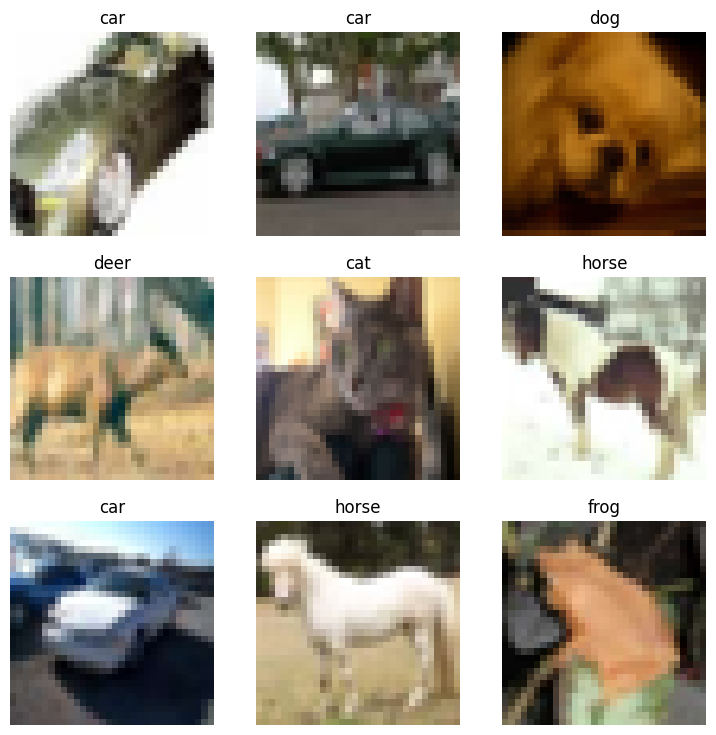

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the appropriate transform, load/download CIFAR10 train and test datasets with transform
# ----------- <Your code> ---------------

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# ----------- <End Your code> ---------------

# Define trainloader and testloader
# ----------- <Your code> ---------------

# Load CIFAR10 train and test datasets with transform (source: Pytorch cifar10_tutorial page)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define trainloader and testloader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=9, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=9, shuffle=False, num_workers=2)

# ----------- <End Your code> ---------------

# Code to display images
batch_idx, (images, targets) = next(enumerate(train_loader))
fig, ax = plt.subplots(3,3,figsize = (9,9))
for i in range(3):
    for j in range(3):
        image = images[i*3+j].permute(1,2,0)
        image = image/2 + 0.5
        ax[i,j].imshow(image)
        ax[i,j].set_axis_off()
        ax[i,j].set_title(f'{classes[targets[i*3+j]]}')
fig.show()

### Task 2: Create CNN and train it
Set up a convolutional neural network and have your data trained on it. You have to decide all the details in your network, overall your neural network should meet the following standards to receive full credit:

*   You should not use more than three convolutional layers and three fully connected layers
*   Accuracy on the test dataset should be **above** 50%



In [ ]:
# Create CNN network.
# ----------- <Your code> ---------------

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cifar_CNN = Net()
net = cifar_CNN.to(device)
print(cifar_CNN)
# ----------- <End Your code> ---------------

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
# Train your neural network here.
# start = time.time() # I started the timer when training/test begins
max_epoch = 4 # Set the number of epochs
# ----------- <Your code> ---------------


# Define the network
net = Net().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Using SGD optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Using Adam optimizer

# Function to train the neural network
def train(net, criterion, train_loader, optimizer, max_epoch):
    net.train()  # Set the model to training mode
    for epoch in range(max_epoch):
        running_loss = 0.0

        # Use tqdm to show progress bar for the training loop
        for i, data in tqdm(enumerate(train_loader, 0), desc=f"Epoch {epoch + 1}/{max_epoch}"):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
                running_loss = 0.0


# Train the neural network
start = time.time()
max_epoch = 4  # Set the number of epochs
train(net, criterion, train_loader, optimizer, max_epoch)
end = time.time()
print(f'Finished Training after {end - start:.2f} seconds')


# Function to test the neural network
def test(net, criterion, test_loader, epoch=1):
    net.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_predictions = []

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.append(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on the test set (Epoch {epoch if epoch is not None else "N/A"}): {accuracy:.2f}%')
    all_preds = torch.cat(all_predictions).cpu()
    return {'prediction': all_predictions, 'accuracy': accuracy}  # Return a dictionary

start = time.time()
# ----------- <End Your code> ---------------
output = test(net, criterion, test_loader, epoch= None)
end = time.time()
print(f'Finished Testing after {end - start:.2f} seconds')

Epoch 1/4: 110it [00:01, 73.20it/s]

[Epoch 1, Batch 100] Loss: 2.216


Epoch 1/4: 212it [00:02, 82.33it/s]

[Epoch 1, Batch 200] Loss: 2.061


Epoch 1/4: 312it [00:03, 85.54it/s]

[Epoch 1, Batch 300] Loss: 1.980


Epoch 1/4: 411it [00:05, 88.22it/s]

[Epoch 1, Batch 400] Loss: 1.897


Epoch 1/4: 514it [00:06, 88.52it/s]

[Epoch 1, Batch 500] Loss: 1.790


Epoch 1/4: 614it [00:07, 90.35it/s]

[Epoch 1, Batch 600] Loss: 1.813


Epoch 1/4: 707it [00:08, 59.36it/s]

[Epoch 1, Batch 700] Loss: 1.819


Epoch 1/4: 805it [00:10, 52.74it/s]

[Epoch 1, Batch 800] Loss: 1.743


Epoch 1/4: 915it [00:12, 85.52it/s]

[Epoch 1, Batch 900] Loss: 1.720


Epoch 1/4: 1014it [00:13, 83.60it/s]

[Epoch 1, Batch 1000] Loss: 1.676


Epoch 1/4: 1114it [00:14, 85.33it/s]

[Epoch 1, Batch 1100] Loss: 1.625


Epoch 1/4: 1208it [00:15, 73.62it/s]

[Epoch 1, Batch 1200] Loss: 1.669


Epoch 1/4: 1317it [00:17, 85.83it/s]

[Epoch 1, Batch 1300] Loss: 1.647


Epoch 1/4: 1411it [00:18, 88.01it/s]

[Epoch 1, Batch 1400] Loss: 1.647


Epoch 1/4: 1514it [00:19, 88.58it/s]

[Epoch 1, Batch 1500] Loss: 1.577


Epoch 1/4: 1616it [00:20, 88.40it/s]

[Epoch 1, Batch 1600] Loss: 1.524


Epoch 1/4: 1706it [00:21, 65.15it/s]

[Epoch 1, Batch 1700] Loss: 1.578


Epoch 1/4: 1809it [00:23, 59.07it/s]

[Epoch 1, Batch 1800] Loss: 1.555


Epoch 1/4: 1915it [00:25, 71.33it/s]

[Epoch 1, Batch 1900] Loss: 1.538


Epoch 1/4: 2011it [00:26, 87.52it/s]

[Epoch 1, Batch 2000] Loss: 1.498


Epoch 1/4: 2116it [00:27, 91.34it/s]

[Epoch 1, Batch 2100] Loss: 1.544


Epoch 1/4: 2209it [00:28, 63.59it/s]

[Epoch 1, Batch 2200] Loss: 1.532


Epoch 1/4: 2309it [00:30, 55.27it/s]

[Epoch 1, Batch 2300] Loss: 1.541


Epoch 1/4: 2414it [00:32, 75.84it/s]

[Epoch 1, Batch 2400] Loss: 1.490


Epoch 1/4: 2513it [00:33, 82.29it/s]

[Epoch 1, Batch 2500] Loss: 1.462


Epoch 1/4: 2611it [00:34, 68.67it/s]

[Epoch 1, Batch 2600] Loss: 1.515


Epoch 1/4: 2707it [00:36, 53.85it/s]

[Epoch 1, Batch 2700] Loss: 1.501


Epoch 1/4: 2804it [00:38, 47.76it/s]

[Epoch 1, Batch 2800] Loss: 1.489


Epoch 1/4: 2910it [00:40, 80.65it/s]

[Epoch 1, Batch 2900] Loss: 1.453


Epoch 1/4: 3012it [00:41, 71.50it/s]

[Epoch 1, Batch 3000] Loss: 1.462


Epoch 1/4: 3110it [00:42, 78.38it/s]

[Epoch 1, Batch 3100] Loss: 1.441


Epoch 1/4: 3216it [00:44, 76.40it/s]

[Epoch 1, Batch 3200] Loss: 1.447


Epoch 1/4: 3315it [00:45, 88.12it/s]

[Epoch 1, Batch 3300] Loss: 1.452


Epoch 1/4: 3409it [00:46, 90.75it/s]

[Epoch 1, Batch 3400] Loss: 1.501


Epoch 1/4: 3512it [00:47, 85.81it/s]

[Epoch 1, Batch 3500] Loss: 1.477


Epoch 1/4: 3611it [00:49, 67.10it/s]

[Epoch 1, Batch 3600] Loss: 1.411


Epoch 1/4: 3708it [00:50, 62.98it/s]

[Epoch 1, Batch 3700] Loss: 1.398


Epoch 1/4: 3808it [00:53, 32.69it/s]

[Epoch 1, Batch 3800] Loss: 1.445


Epoch 1/4: 3902it [00:56, 30.26it/s]

[Epoch 1, Batch 3900] Loss: 1.358


Epoch 1/4: 4013it [00:58, 75.97it/s]

[Epoch 1, Batch 4000] Loss: 1.377


Epoch 1/4: 4110it [00:59, 75.96it/s]

[Epoch 1, Batch 4100] Loss: 1.364


Epoch 1/4: 4212it [01:01, 81.38it/s]

[Epoch 1, Batch 4200] Loss: 1.402


Epoch 1/4: 4313it [01:02, 86.65it/s]

[Epoch 1, Batch 4300] Loss: 1.340


Epoch 1/4: 4404it [01:03, 61.31it/s]

[Epoch 1, Batch 4400] Loss: 1.345


Epoch 1/4: 4507it [01:05, 55.20it/s]

[Epoch 1, Batch 4500] Loss: 1.425


Epoch 1/4: 4609it [01:06, 81.80it/s]

[Epoch 1, Batch 4600] Loss: 1.385


Epoch 1/4: 4714it [01:08, 80.68it/s]

[Epoch 1, Batch 4700] Loss: 1.363


Epoch 1/4: 4816it [01:09, 83.75it/s]

[Epoch 1, Batch 4800] Loss: 1.400


Epoch 1/4: 4908it [01:10, 87.23it/s]

[Epoch 1, Batch 4900] Loss: 1.373


Epoch 1/4: 5010it [01:11, 69.99it/s]

[Epoch 1, Batch 5000] Loss: 1.453


Epoch 1/4: 5117it [01:13, 81.40it/s]

[Epoch 1, Batch 5100] Loss: 1.370


Epoch 1/4: 5211it [01:14, 88.03it/s]

[Epoch 1, Batch 5200] Loss: 1.396


Epoch 1/4: 5313it [01:15, 76.80it/s]

[Epoch 1, Batch 5300] Loss: 1.324


Epoch 1/4: 5410it [01:17, 54.87it/s]

[Epoch 1, Batch 5400] Loss: 1.355


Epoch 1/4: 5509it [01:19, 48.55it/s]

[Epoch 1, Batch 5500] Loss: 1.408


Epoch 1/4: 5556it [01:20, 69.27it/s]
Epoch 2/4: 116it [00:01, 85.65it/s]

[Epoch 2, Batch 100] Loss: 1.292


Epoch 2/4: 207it [00:02, 82.92it/s]

[Epoch 2, Batch 200] Loss: 1.321


Epoch 2/4: 309it [00:03, 81.09it/s]

[Epoch 2, Batch 300] Loss: 1.306


Epoch 2/4: 412it [00:04, 87.20it/s]

[Epoch 2, Batch 400] Loss: 1.268


Epoch 2/4: 514it [00:06, 87.35it/s]

[Epoch 2, Batch 500] Loss: 1.297


Epoch 2/4: 618it [00:07, 89.66it/s]

[Epoch 2, Batch 600] Loss: 1.312


Epoch 2/4: 711it [00:08, 84.76it/s]

[Epoch 2, Batch 700] Loss: 1.243


Epoch 2/4: 815it [00:09, 83.83it/s]

[Epoch 2, Batch 800] Loss: 1.261


Epoch 2/4: 905it [00:11, 52.09it/s]

[Epoch 2, Batch 900] Loss: 1.292


Epoch 2/4: 1009it [00:13, 52.84it/s]

[Epoch 2, Batch 1000] Loss: 1.264


Epoch 2/4: 1111it [00:14, 82.47it/s]

[Epoch 2, Batch 1100] Loss: 1.284


Epoch 2/4: 1215it [00:15, 87.81it/s]

[Epoch 2, Batch 1200] Loss: 1.307


Epoch 2/4: 1311it [00:16, 89.15it/s]

[Epoch 2, Batch 1300] Loss: 1.352


Epoch 2/4: 1411it [00:18, 74.59it/s]

[Epoch 2, Batch 1400] Loss: 1.266


Epoch 2/4: 1509it [00:19, 70.55it/s]

[Epoch 2, Batch 1500] Loss: 1.231


Epoch 2/4: 1611it [00:20, 80.38it/s]

[Epoch 2, Batch 1600] Loss: 1.252


Epoch 2/4: 1714it [00:22, 87.76it/s]

[Epoch 2, Batch 1700] Loss: 1.287


Epoch 2/4: 1815it [00:23, 88.40it/s]

[Epoch 2, Batch 1800] Loss: 1.296


Epoch 2/4: 1905it [00:24, 53.84it/s]

[Epoch 2, Batch 1900] Loss: 1.237


Epoch 2/4: 2006it [00:26, 49.24it/s]

[Epoch 2, Batch 2000] Loss: 1.231


Epoch 2/4: 2112it [00:28, 76.49it/s]

[Epoch 2, Batch 2100] Loss: 1.282


Epoch 2/4: 2209it [00:29, 74.42it/s]

[Epoch 2, Batch 2200] Loss: 1.275


Epoch 2/4: 2317it [00:30, 77.94it/s]

[Epoch 2, Batch 2300] Loss: 1.212


Epoch 2/4: 2417it [00:32, 84.79it/s]

[Epoch 2, Batch 2400] Loss: 1.185


Epoch 2/4: 2509it [00:33, 85.76it/s]

[Epoch 2, Batch 2500] Loss: 1.273


Epoch 2/4: 2610it [00:34, 86.21it/s]

[Epoch 2, Batch 2600] Loss: 1.294


Epoch 2/4: 2711it [00:35, 84.22it/s]

[Epoch 2, Batch 2700] Loss: 1.264


Epoch 2/4: 2815it [00:36, 87.17it/s]

[Epoch 2, Batch 2800] Loss: 1.231


Epoch 2/4: 2912it [00:38, 60.02it/s]

[Epoch 2, Batch 2900] Loss: 1.278


Epoch 2/4: 3007it [00:39, 55.77it/s]

[Epoch 2, Batch 3000] Loss: 1.178


Epoch 2/4: 3114it [00:41, 78.95it/s]

[Epoch 2, Batch 3100] Loss: 1.325


Epoch 2/4: 3213it [00:42, 73.97it/s]

[Epoch 2, Batch 3200] Loss: 1.265


Epoch 2/4: 3311it [00:44, 85.05it/s]

[Epoch 2, Batch 3300] Loss: 1.263


Epoch 2/4: 3412it [00:45, 85.75it/s]

[Epoch 2, Batch 3400] Loss: 1.226


Epoch 2/4: 3507it [00:46, 87.79it/s]

[Epoch 2, Batch 3500] Loss: 1.192


Epoch 2/4: 3614it [00:47, 87.49it/s]

[Epoch 2, Batch 3600] Loss: 1.258


Epoch 2/4: 3713it [00:48, 74.62it/s]

[Epoch 2, Batch 3700] Loss: 1.229


Epoch 2/4: 3812it [00:50, 86.36it/s]

[Epoch 2, Batch 3800] Loss: 1.288


Epoch 2/4: 3904it [00:51, 69.67it/s]

[Epoch 2, Batch 3900] Loss: 1.126


Epoch 2/4: 4010it [00:53, 55.18it/s]

[Epoch 2, Batch 4000] Loss: 1.315


Epoch 2/4: 4115it [00:54, 70.48it/s]

[Epoch 2, Batch 4100] Loss: 1.294


Epoch 2/4: 4209it [00:55, 86.33it/s]

[Epoch 2, Batch 4200] Loss: 1.224


Epoch 2/4: 4308it [00:57, 77.89it/s]

[Epoch 2, Batch 4300] Loss: 1.209


Epoch 2/4: 4411it [00:58, 88.37it/s]

[Epoch 2, Batch 4400] Loss: 1.291


Epoch 2/4: 4514it [00:59, 88.47it/s]

[Epoch 2, Batch 4500] Loss: 1.252


Epoch 2/4: 4617it [01:00, 87.97it/s]

[Epoch 2, Batch 4600] Loss: 1.203


Epoch 2/4: 4717it [01:01, 84.91it/s]

[Epoch 2, Batch 4700] Loss: 1.285


Epoch 2/4: 4811it [01:03, 85.10it/s]

[Epoch 2, Batch 4800] Loss: 1.323


Epoch 2/4: 4911it [01:04, 83.87it/s]

[Epoch 2, Batch 4900] Loss: 1.226


Epoch 2/4: 5007it [01:05, 59.54it/s]

[Epoch 2, Batch 5000] Loss: 1.196


Epoch 2/4: 5109it [01:07, 49.23it/s]

[Epoch 2, Batch 5100] Loss: 1.156


Epoch 2/4: 5210it [01:09, 69.89it/s]

[Epoch 2, Batch 5200] Loss: 1.225


Epoch 2/4: 5313it [01:10, 87.44it/s]

[Epoch 2, Batch 5300] Loss: 1.206


Epoch 2/4: 5413it [01:12, 87.21it/s]

[Epoch 2, Batch 5400] Loss: 1.168


Epoch 2/4: 5517it [01:13, 89.05it/s]

[Epoch 2, Batch 5500] Loss: 1.243


Epoch 2/4: 5556it [01:13, 75.35it/s]
Epoch 3/4: 109it [00:01, 88.36it/s]

[Epoch 3, Batch 100] Loss: 1.164


Epoch 3/4: 212it [00:02, 88.79it/s]

[Epoch 3, Batch 200] Loss: 1.183


Epoch 3/4: 308it [00:03, 75.26it/s]

[Epoch 3, Batch 300] Loss: 1.142


Epoch 3/4: 406it [00:05, 55.32it/s]

[Epoch 3, Batch 400] Loss: 1.176


Epoch 3/4: 504it [00:08, 21.75it/s]

[Epoch 3, Batch 500] Loss: 1.097


Epoch 3/4: 604it [00:11, 31.44it/s]

[Epoch 3, Batch 600] Loss: 1.167


Epoch 3/4: 716it [00:13, 83.90it/s]

[Epoch 3, Batch 700] Loss: 1.183


Epoch 3/4: 817it [00:14, 86.14it/s]

[Epoch 3, Batch 800] Loss: 1.174


Epoch 3/4: 910it [00:15, 86.63it/s]

[Epoch 3, Batch 900] Loss: 1.179


Epoch 3/4: 1011it [00:16, 85.24it/s]

[Epoch 3, Batch 1000] Loss: 1.150


Epoch 3/4: 1102it [00:19, 21.55it/s]

[Epoch 3, Batch 1100] Loss: 1.142


Epoch 3/4: 1206it [00:23, 40.79it/s]

[Epoch 3, Batch 1200] Loss: 1.170


Epoch 3/4: 1314it [00:25, 76.85it/s]

[Epoch 3, Batch 1300] Loss: 1.148


Epoch 3/4: 1417it [00:26, 88.74it/s]

[Epoch 3, Batch 1400] Loss: 1.210


Epoch 3/4: 1510it [00:27, 86.33it/s]

[Epoch 3, Batch 1500] Loss: 1.070


Epoch 3/4: 1606it [00:28, 74.53it/s]

[Epoch 3, Batch 1600] Loss: 1.152


Epoch 3/4: 1711it [00:30, 75.14it/s]

[Epoch 3, Batch 1700] Loss: 1.176


Epoch 3/4: 1810it [00:31, 73.93it/s]

[Epoch 3, Batch 1800] Loss: 1.187


Epoch 3/4: 1911it [00:32, 74.67it/s]

[Epoch 3, Batch 1900] Loss: 1.091


Epoch 3/4: 2010it [00:34, 51.75it/s]

[Epoch 3, Batch 2000] Loss: 1.098


Epoch 3/4: 2112it [00:37, 54.21it/s]

[Epoch 3, Batch 2100] Loss: 1.110


Epoch 3/4: 2214it [00:38, 75.21it/s]

[Epoch 3, Batch 2200] Loss: 1.046


Epoch 3/4: 2306it [00:40, 34.14it/s]

[Epoch 3, Batch 2300] Loss: 1.126


Epoch 3/4: 2411it [00:42, 88.15it/s]

[Epoch 3, Batch 2400] Loss: 1.174


Epoch 3/4: 2507it [00:44, 48.25it/s]

[Epoch 3, Batch 2500] Loss: 1.114


Epoch 3/4: 2612it [00:45, 86.09it/s]

[Epoch 3, Batch 2600] Loss: 1.134


Epoch 3/4: 2708it [00:46, 84.38it/s]

[Epoch 3, Batch 2700] Loss: 1.148


Epoch 3/4: 2811it [00:48, 57.56it/s]

[Epoch 3, Batch 2800] Loss: 1.190


Epoch 3/4: 2904it [00:50, 54.57it/s]

[Epoch 3, Batch 2900] Loss: 1.207


Epoch 3/4: 3007it [00:52, 49.74it/s]

[Epoch 3, Batch 3000] Loss: 1.148


Epoch 3/4: 3111it [00:53, 88.56it/s]

[Epoch 3, Batch 3100] Loss: 1.155


Epoch 3/4: 3208it [00:54, 91.19it/s]

[Epoch 3, Batch 3200] Loss: 1.163


Epoch 3/4: 3314it [00:55, 82.84it/s]

[Epoch 3, Batch 3300] Loss: 1.168


Epoch 3/4: 3418it [00:57, 86.80it/s]

[Epoch 3, Batch 3400] Loss: 1.068


Epoch 3/4: 3511it [00:58, 87.82it/s]

[Epoch 3, Batch 3500] Loss: 1.109


Epoch 3/4: 3612it [00:59, 77.36it/s]

[Epoch 3, Batch 3600] Loss: 1.163


Epoch 3/4: 3708it [01:00, 64.77it/s]

[Epoch 3, Batch 3700] Loss: 1.059


Epoch 3/4: 3809it [01:02, 54.26it/s]

[Epoch 3, Batch 3800] Loss: 1.115


Epoch 3/4: 3912it [01:04, 77.01it/s]

[Epoch 3, Batch 3900] Loss: 1.165


Epoch 3/4: 4014it [01:05, 87.87it/s]

[Epoch 3, Batch 4000] Loss: 1.114


Epoch 3/4: 4115it [01:06, 84.74it/s]

[Epoch 3, Batch 4100] Loss: 1.135


Epoch 3/4: 4209it [01:07, 87.75it/s]

[Epoch 3, Batch 4200] Loss: 1.152


Epoch 3/4: 4313it [01:08, 76.74it/s]

[Epoch 3, Batch 4300] Loss: 1.152


Epoch 3/4: 4416it [01:10, 84.62it/s]

[Epoch 3, Batch 4400] Loss: 1.103


Epoch 3/4: 4508it [01:12, 37.34it/s]

[Epoch 3, Batch 4500] Loss: 1.031


Epoch 3/4: 4609it [01:14, 47.36it/s]

[Epoch 3, Batch 4600] Loss: 1.108


Epoch 3/4: 4704it [01:17, 45.23it/s]

[Epoch 3, Batch 4700] Loss: 1.212


Epoch 3/4: 4811it [01:19, 53.51it/s]

[Epoch 3, Batch 4800] Loss: 1.057


Epoch 3/4: 4906it [01:20, 70.08it/s]

[Epoch 3, Batch 4900] Loss: 1.141


Epoch 3/4: 5009it [01:21, 85.47it/s]

[Epoch 3, Batch 5000] Loss: 1.138


Epoch 3/4: 5113it [01:23, 85.45it/s]

[Epoch 3, Batch 5100] Loss: 1.113


Epoch 3/4: 5208it [01:24, 82.33it/s]

[Epoch 3, Batch 5200] Loss: 1.101


Epoch 3/4: 5316it [01:25, 87.12it/s]

[Epoch 3, Batch 5300] Loss: 1.101


Epoch 3/4: 5410it [01:26, 85.25it/s]

[Epoch 3, Batch 5400] Loss: 1.068


Epoch 3/4: 5513it [01:28, 70.99it/s]

[Epoch 3, Batch 5500] Loss: 1.140


Epoch 3/4: 5556it [01:28, 62.71it/s]
Epoch 4/4: 110it [00:01, 69.08it/s]

[Epoch 4, Batch 100] Loss: 0.989


Epoch 4/4: 208it [00:03, 52.99it/s]

[Epoch 4, Batch 200] Loss: 1.013


Epoch 4/4: 312it [00:05, 57.93it/s]

[Epoch 4, Batch 300] Loss: 1.066


Epoch 4/4: 409it [00:06, 77.18it/s]

[Epoch 4, Batch 400] Loss: 1.008


Epoch 4/4: 511it [00:07, 80.63it/s]

[Epoch 4, Batch 500] Loss: 1.037


Epoch 4/4: 610it [00:09, 72.91it/s]

[Epoch 4, Batch 600] Loss: 1.087


Epoch 4/4: 710it [00:10, 81.50it/s]

[Epoch 4, Batch 700] Loss: 1.058


Epoch 4/4: 811it [00:11, 85.42it/s]

[Epoch 4, Batch 800] Loss: 1.100


Epoch 4/4: 912it [00:12, 85.97it/s]

[Epoch 4, Batch 900] Loss: 1.010


Epoch 4/4: 1011it [00:13, 75.86it/s]

[Epoch 4, Batch 1000] Loss: 1.040


Epoch 4/4: 1108it [00:15, 61.66it/s]

[Epoch 4, Batch 1100] Loss: 1.130


Epoch 4/4: 1205it [00:17, 33.43it/s]

[Epoch 4, Batch 1200] Loss: 1.053


Epoch 4/4: 1305it [00:20, 36.95it/s]

[Epoch 4, Batch 1300] Loss: 1.039


Epoch 4/4: 1407it [00:22, 57.35it/s]

[Epoch 4, Batch 1400] Loss: 1.044


Epoch 4/4: 1508it [00:23, 59.05it/s]

[Epoch 4, Batch 1500] Loss: 1.130


Epoch 4/4: 1612it [00:25, 59.16it/s]

[Epoch 4, Batch 1600] Loss: 1.013


Epoch 4/4: 1706it [00:27, 45.09it/s]

[Epoch 4, Batch 1700] Loss: 1.053


Epoch 4/4: 1808it [00:30, 45.92it/s]

[Epoch 4, Batch 1800] Loss: 1.053


Epoch 4/4: 1908it [00:32, 56.01it/s]

[Epoch 4, Batch 1900] Loss: 0.992


Epoch 4/4: 2005it [00:35, 31.27it/s]

[Epoch 4, Batch 2000] Loss: 1.085


Epoch 4/4: 2109it [00:38, 53.14it/s]

[Epoch 4, Batch 2100] Loss: 1.094


Epoch 4/4: 2208it [00:39, 77.84it/s]

[Epoch 4, Batch 2200] Loss: 1.010


Epoch 4/4: 2305it [00:41, 54.23it/s]

[Epoch 4, Batch 2300] Loss: 1.030


Epoch 4/4: 2414it [00:43, 71.84it/s]

[Epoch 4, Batch 2400] Loss: 1.070


Epoch 4/4: 2511it [00:44, 73.33it/s]

[Epoch 4, Batch 2500] Loss: 1.067


Epoch 4/4: 2606it [00:46, 53.84it/s]

[Epoch 4, Batch 2600] Loss: 1.050


Epoch 4/4: 2705it [00:47, 51.23it/s]

[Epoch 4, Batch 2700] Loss: 1.051


Epoch 4/4: 2817it [00:49, 83.72it/s]

[Epoch 4, Batch 2800] Loss: 1.074


Epoch 4/4: 2916it [00:50, 81.84it/s]

[Epoch 4, Batch 2900] Loss: 1.058


Epoch 4/4: 3010it [00:51, 80.92it/s]

[Epoch 4, Batch 3000] Loss: 1.086


Epoch 4/4: 3110it [00:53, 82.71it/s]

[Epoch 4, Batch 3100] Loss: 1.009


Epoch 4/4: 3212it [00:54, 83.67it/s]

[Epoch 4, Batch 3200] Loss: 1.061


Epoch 4/4: 3317it [00:55, 88.31it/s]

[Epoch 4, Batch 3300] Loss: 1.013


Epoch 4/4: 3412it [00:56, 89.17it/s]

[Epoch 4, Batch 3400] Loss: 1.048


Epoch 4/4: 3516it [00:57, 84.69it/s]

[Epoch 4, Batch 3500] Loss: 1.005


Epoch 4/4: 3605it [00:59, 62.83it/s]

[Epoch 4, Batch 3600] Loss: 1.074


Epoch 4/4: 3707it [01:01, 51.99it/s]

[Epoch 4, Batch 3700] Loss: 1.011


Epoch 4/4: 3811it [01:02, 67.14it/s]

[Epoch 4, Batch 3800] Loss: 1.067


Epoch 4/4: 3912it [01:04, 83.28it/s]

[Epoch 4, Batch 3900] Loss: 1.027


Epoch 4/4: 4013it [01:05, 85.83it/s]

[Epoch 4, Batch 4000] Loss: 1.042


Epoch 4/4: 4109it [01:06, 83.01it/s]

[Epoch 4, Batch 4100] Loss: 1.103


Epoch 4/4: 4212it [01:07, 87.83it/s]

[Epoch 4, Batch 4200] Loss: 1.071


Epoch 4/4: 4311it [01:09, 70.94it/s]

[Epoch 4, Batch 4300] Loss: 1.073


Epoch 4/4: 4411it [01:10, 78.31it/s]

[Epoch 4, Batch 4400] Loss: 1.098


Epoch 4/4: 4511it [01:11, 81.53it/s]

[Epoch 4, Batch 4500] Loss: 1.039


Epoch 4/4: 4611it [01:12, 84.03it/s]

[Epoch 4, Batch 4600] Loss: 1.053


Epoch 4/4: 4707it [01:14, 56.29it/s]

[Epoch 4, Batch 4700] Loss: 1.054


Epoch 4/4: 4806it [01:16, 53.72it/s]

[Epoch 4, Batch 4800] Loss: 1.076


Epoch 4/4: 4918it [01:17, 85.86it/s]

[Epoch 4, Batch 4900] Loss: 1.012


Epoch 4/4: 5009it [01:18, 85.54it/s]

[Epoch 4, Batch 5000] Loss: 1.135


Epoch 4/4: 5111it [01:19, 88.72it/s]

[Epoch 4, Batch 5100] Loss: 1.023


Epoch 4/4: 5213it [01:21, 85.05it/s]

[Epoch 4, Batch 5200] Loss: 1.036


Epoch 4/4: 5314it [01:22, 84.60it/s]

[Epoch 4, Batch 5300] Loss: 0.997


Epoch 4/4: 5416it [01:23, 81.68it/s]

[Epoch 4, Batch 5400] Loss: 1.038


Epoch 4/4: 5509it [01:24, 80.49it/s]

[Epoch 4, Batch 5500] Loss: 1.137


Epoch 4/4: 5556it [01:25, 65.20it/s]

Finished Training after 328.07 seconds


Accuracy on the test set (Epoch N/A): 60.22%
Finished Testing after 8.53 seconds


Test accuracy above 50% achieved!

### Task 3: Plot misclassified test images
Plot some misclassified images in your test dataset:

*   select three images that are **misclassified** by your neural network
*   label each images with true label and predicted label
*   use `detach().cpu()` when plotting images if the image is in gpu

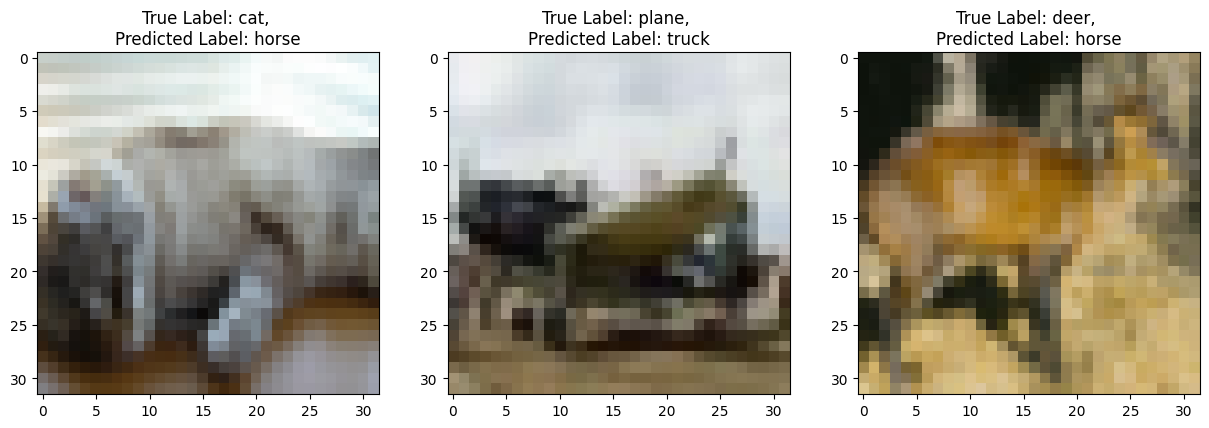

In [ ]:
total_images = 3
predictions = output['prediction']
targets = torch.tensor(testset.targets)

# ----------- <Your code> ---------------

# Identify misclassified indices
misclassified_indices = []
all_predictions = torch.cat(output['prediction'])

# Append to the list of all miscalssified indices
for i in range(len(all_predictions)):
    if all_predictions[i] != targets[i]:
        misclassified_indices.append(i)

# Convert to tensor
misclassified_indices = torch.tensor(misclassified_indices)

# Select three random misclassified images
total_images = 3
# misclassified_images = misclassified_indices[:total_images]
misclassified_images = misclassified_indices[torch.randperm(len(misclassified_indices))[:total_images]]
# Plot misclassified images
fig, ax = plt.subplots(1, total_images, figsize=(15, 5))
for i, index in enumerate(misclassified_images):
    image = testset.data[index].transpose((2, 0, 1))  # Transpose to (Channel, Height, Width)
    image = torch.tensor(image).float() / 255.0  # Normalize image to [0, 1]

    # Check if image is on GPU and move to CPU if necessary
    # Move to CPU and detach from graph as per guideline
    if image.is_cuda:
        image = image.detach().cpu()
    ax[i].imshow(image.permute(1, 2, 0).detach().cpu())

    # Convert true and predicted class indices
    true_class_index = targets[index].cpu().numpy().item() # True label
    pred_class_index = all_predictions[index].cpu().numpy().item() # Predicted label
    # Define label per panel
    ax[i].set_title(f'True Label: {classes[true_class_index]}, \nPredicted Label: {classes[pred_class_index]}')
    ax[i].axis('on')

plt.show()

# ----------- <End Your code> ---------------

Below is ungraded and for my own curiosity

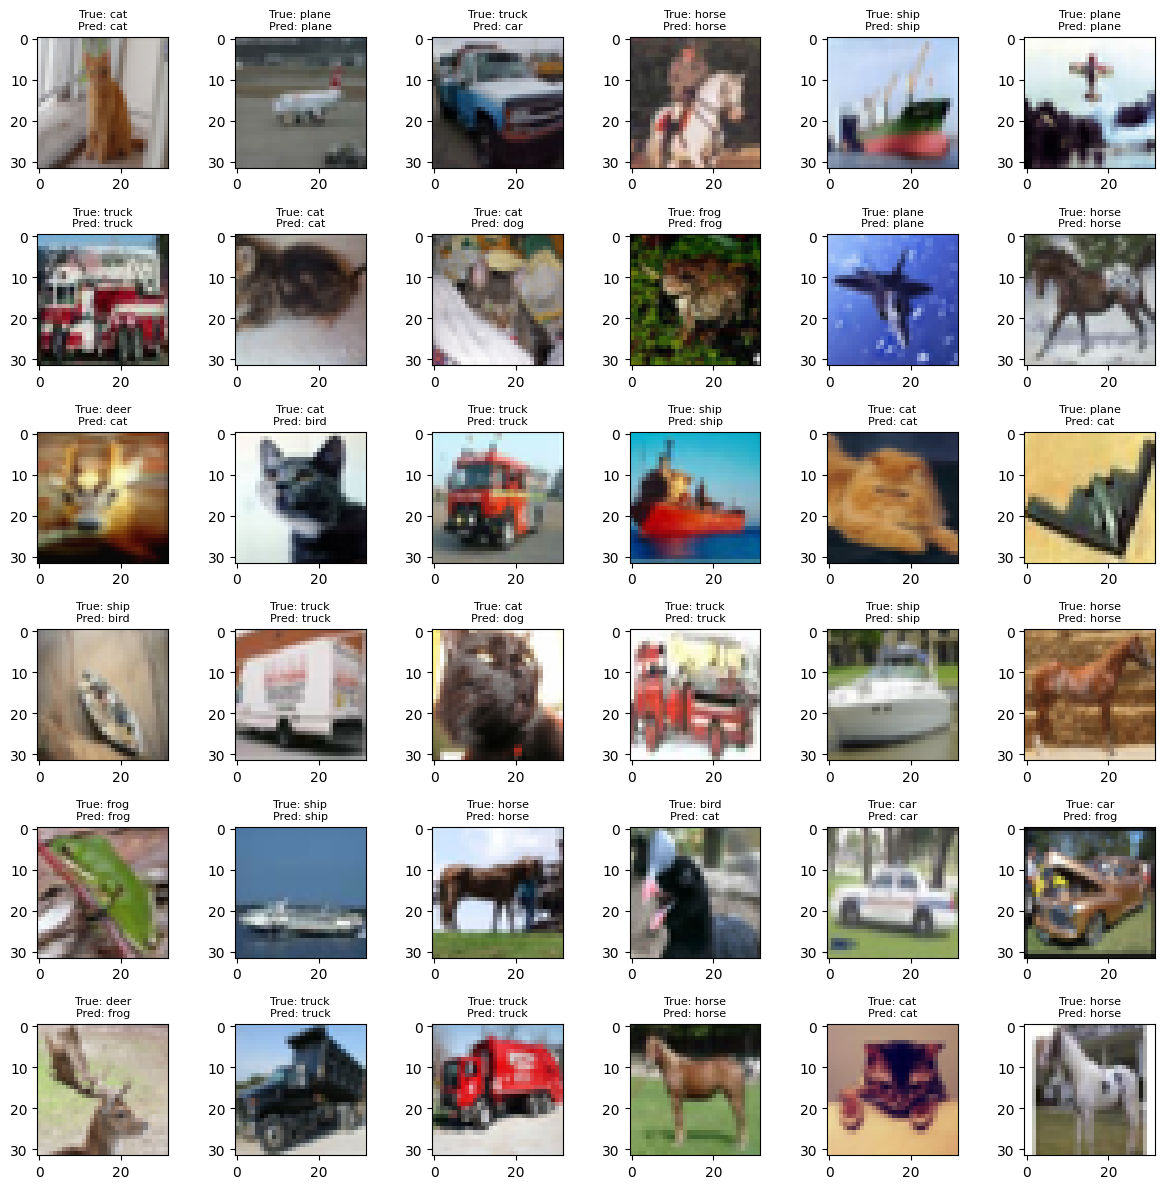

In [ ]:
# Number of random images to display in 6x6 Grid
total_images = 36
predictions = torch.cat(output['prediction'])
targets = torch.tensor(testset.targets)

# Randomly select any 36 images from the test set
random_indices = torch.randperm(len(testset))[:total_images]
# Create a 6x6 grid for plotting
fig, ax = plt.subplots(6, 6, figsize=(12, 12))
# Plot the randomly selected images
for i, index in enumerate(random_indices):
    image = testset.data[index].transpose((2, 0, 1))
    image = image / 255.0
    row, col = divmod(i, 6)
    ax[row, col].imshow(image.transpose(1, 2, 0))
    true_label = classes[targets[index].item()]
    pred_label = classes[predictions[index].item()]
    ax[row, col].set_title(f'True: {true_label}\nPred: {pred_label}', fontsize=8)
    ax[row, col].axis('on')
plt.tight_layout()
plt.show()

Questions (0 points): Are the mis-classified images also misleading to human eyes?

Only in some cases pixelated images are misleading to even human eyes.

## Exercise 3: Transfer Learning (30 points)

In practice, people won't train an entire CNN from scratch, because it is relatively rare to have a dataset of sufficient size (or sufficient computational power). Instead, it is common to pretrain a CNN on a very large dataset and then use the CNN either as an initialization or a fixed feature extractor for the task of interest.

In this task, you will learn how to use a pretrained CNN for CIFAR-10 classification.

### Task1: Load pretrained model

`torchvision.models` (https://pytorch.org/vision/stable/models.html) contains definitions of models for addressing different tasks, including: image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection and video classification.

First, you should load the **pretrained** ResNet-18 that has already been trained on [ImageNet](https://www.image-net.org/) using `torchvision.models`. If you are interested in more details about Resnet-18, read this paper https://arxiv.org/pdf/1512.03385.pdf.

In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device)
print(resnet18) # Check architechture

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Here is better way to vizulalize. https://github.com/mert-kurttutan/torchview

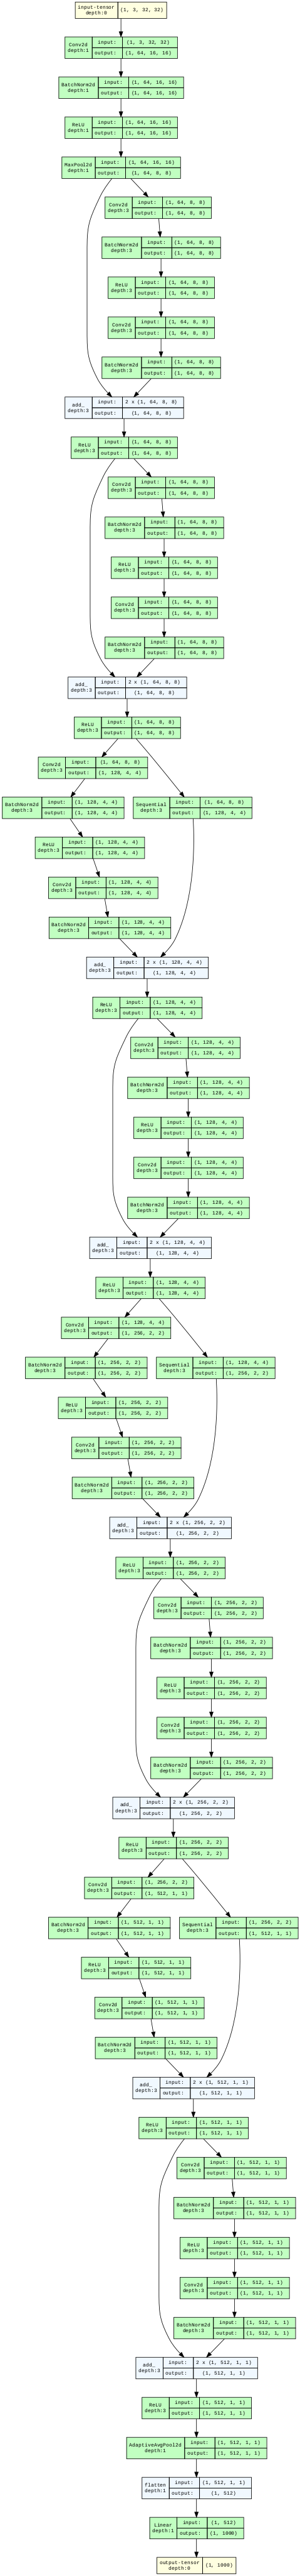

In [ ]:
!pip install torchview
!pip install graphviz
import graphviz
from torchview import draw_graph
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
graphviz.set_jupyter_format('png')

model_graph = draw_graph(resnet18(), input_size=(1,3,32,32))
model_graph.visual_graph

### Task2: Create data loaders for CIFAR-10

Then you need to create a modified dataset and dataloader for CIFAR-10. Importantly, the model you load has been trained on **ImageNet** and it expects inputs as mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be **at least** 224. So you need to preprocess the CIFAR-10 data to make sure it has a height and width of 224. Thus, you should add a transform when loading the CIFAR10 dataset (see [`torchvision.transforms.Resize`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize)).
This should be added appropriately to the `transform` you created in a previous task.

In [ ]:
# Create your dataloader here
# ----------- <Your code> ---------------

# Define the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 HxW
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize (https://pytorch.org/vision/2.0/models/generated/torchvision.models.resnet18.html)
])

# Create the CIFAR-10 training dataset
cifar10_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create the DataLoader for the training dataset
cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=32, shuffle=True)

# Create the CIFAR-10 test dataset
cifar10_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create the DataLoader for the test dataset
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=32, shuffle=False)

# ----------- <End Your code> ---------------

100%|██████████| 170498071/170498071 [00:01<00:00, 86673716.70it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Task3: Classify test data on pretrained model

Use the model you load to classify the **test** CIFAR-10 data and print out the test accuracy.

Don't be surprised if the accuracy is bad!

In [ ]:
# ----------- <Your code> ---------------

# Load original pretrained ResNet18 model
original_resnet18 = models.resnet18(pretrained=True)
# Move model to the appropriate device (GPU if available)
original_resnet18.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

def test(model, criterion, test_loader, epoch):

    model.eval()  # Set the model to evaluation mode
    # Initialize
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient calculation for evaluation
        for batch_idx, (images, targets) in enumerate(test_loader):
            images, targets = images.to(device), targets.to(device)  # Move data to GPU if available
            output = model(images)  # Forward pass

            # Calculate the loss for the current batch
            loss = criterion(output, targets)
            test_loss += loss.item() * images.size(0)

            # Get predictions
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(targets.view_as(pred)).sum().item()
            total += targets.size(0)  # Total samples processed

            # Print statistics every 100 batches
            if batch_idx % 100 == 0 and batch_idx != 0:
                accuracy = 100. * correct / total
                print(f'Batch {batch_idx}: Loss so far: {test_loss / total:.4f}, Accuracy so far: {accuracy:.2f}%')

    # Compute average test loss and accuracy
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    # Print final test results for the epoch
    print(f'Test result on epoch {epoch}: Avg loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Testing loop for multiple epochs
max_epoch = 1  # Set the number of epochs
for epoch in range(1, max_epoch + 1):
    test(original_resnet18, criterion, cifar10_test_loader, epoch =epoch)

# ----------- <End Your code> ---------------

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Batch 100: Loss so far: 13.5618, Accuracy so far: 0.00%
Batch 200: Loss so far: 13.5605, Accuracy so far: 0.00%
Batch 300: Loss so far: 13.5504, Accuracy so far: 0.00%
Test result on epoch 1: Avg loss: 13.5529, Accuracy: 0.00%


### Task 4: Fine-tune (i.e., update) the pretrained model for CIFAR-10

Now try to improve the test accuracy. We offer several possible solutions:

(1) You can try to directly continue to train the model you load with the CIFAR-10 training data.

(2) For efficiency, you can try to freeze part of the parameters of the loaded models. For example, you can first freeze all parameters by

```
for param in model.parameters():
    param.requires_grad = False
```
and then unfreeze the last few layers by setting `somelayer.requires_grad=True`.

You are also welcome to try any other approach you can think of.


**Note:** You must print out the test accuracy and to get full credits, the test accuracy should be at least **80%**.

In [ ]:
# (1) Directly train the whole model and optimize model to improve accuracy
# start = time.time()
# ----------- <Your code> ---------------

# Copy of original model
my_resnet1 = copy.deepcopy(original_resnet18)
my_resnet1.to(device) # Move to GPU if available

# Mofidying ResNet18 output to 10 classes corresponding to the dataset class for better training
num_classes = max(len(cifar10_train_dataset.classes), len(cifar10_test_dataset.classes))
my_resnet1.fc.out_features = num_classes

print(my_resnet1) # Check modified architechture
max_epoch =3
# Define the loss function (criterion) and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_resnet1.parameters(), lr=0.001)


# Define training function
def train(model, criterion, optimizer, train_loader, epoch):

    # Initialize training parameters
    train_losses = []  # Track losses over time
    train_counter = []  # Track which batch was processed for plotting
    running_loss = 0.0 # Inilialize loss to zero


    # Training loop
    model.train()  # Set the model to training mode

    for epoch in range(max_epoch):

        for batch_idx, (images, labels) in enumerate(train_loader):
            # Move images and labels to the GPU here
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
             # Accumulate loss for running statistics
            running_loss += loss.item()

            # Print loss every 100 batches
            if batch_idx % 100 == 0 and batch_idx != 0:
                train_losses.append(loss.item())  # Record the loss
                train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
                print(f'Epoch {epoch + 1}: [{batch_idx * len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')

            # Print statistics every 100 batches
            if batch_idx % 100 == 0:  # Every 100 batches
                print(f'Epoch {epoch + 1}: [{batch_idx * len(images)}/{len(train_loader.dataset)}] Running Loss: {running_loss / 100:.3f}')
                running_loss = 0.0  # Reset the running loss

    return model

# Define test function
def test(model, criterion, test_loader, epoch):

    # Test loop
    model.eval() # Setting the model to evaluation mode

    # Initialize test statistics
    test_loss = 0.0
    correct = 0

    num_test_samples = len(test_loader.dataset)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Update the test loss
            test_loss += loss.item() * images.size(0)

            # Compute test accuracy
            pred = outputs.data.max(1, keepdim=True)[1]  # Get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()

    # Compute average test loss and accuracy
    test_loss /= len(test_loader.dataset)  # Average loss over all samples
    accuracy = 100. * correct / len(test_loader.dataset)

    # Print test results
    print(f'{model} Test result on epoch {epoch}: Avg loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return test_loss, accuracy

start = time.time()
# Training code
my_resnet1 = train(my_resnet1, criterion, optimizer, cifar10_train_loader, epoch= max_epoch)
end = time.time()
print(f'Finished Training after {end-start} s ')
# ----------- <End Your code> ---------------
start = time.time()
test(my_resnet1, criterion, cifar10_test_loader, epoch= None)
end = time.time()
print(f'Finished Testing after {end-start} s ')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Above 80% accuracy achieved on the first modified instance of ResNet18

In [ ]:
# Load another resnet18 instance, only unfreeze the outer layers.
# ----------- <Your code> ---------------
my_resnet2 = copy.deepcopy(original_resnet18) # One for transfer learning
my_resnet2.to(device) # Move to GPU if available

print(my_resnet2) # Verifying the copy of original ResNet18

# First we modify the last fully connected layer (fc) to match the number of CIFAR-10 classes (10)
num_classes = my_resnet2.fc.in_features
my_resnet2.fc = nn.Linear(num_classes, 10)
print(my_resnet2.fc) # Print just to be sure!

# Freeze all layers in the model
for param in my_resnet2.parameters():
    param.requires_grad = False

# Unfreeze the last block (layer4) and the fully connected layer (fc)
for param in my_resnet2.layer4.parameters():
    param.requires_grad = True
for param in my_resnet2.fc.parameters():
    param.requires_grad = True

# ----------- <End Your code> ---------------

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Train the model!!
start = time.time()
# ----------- <Your code> ---------------

# Move the modified model to the device
my_resnet2 = my_resnet2.to(device)

# Define the loss function and optimizer (only for unfrozen layers)
criterion = nn.CrossEntropyLoss() # Usual cross entropy
optimizer = optim.Adam(filter(lambda p: p.requires_grad, my_resnet2.parameters()), lr=0.001)  # Only optimize the unfrozen layers

# Start Training the model
my_resnet2 = train(my_resnet2, criterion, optimizer, cifar10_train_loader, epoch= 3)

# ----------- <End Your code> ---------------
test(my_resnet2, criterion, cifar10_train_loader, epoch=1)

end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/50000] Running Loss: 0.027
Epoch 1: [3200/50000] Loss: 0.5426775813102722
Epoch 1: [3200/50000] Running Loss: 0.855
Epoch 1: [6400/50000] Loss: 0.5179008841514587
Epoch 1: [6400/50000] Running Loss: 0.616
Epoch 1: [9600/50000] Loss: 0.5870295763015747
Epoch 1: [9600/50000] Running Loss: 0.598
Epoch 1: [12800/50000] Loss: 0.6509610414505005
Epoch 1: [12800/50000] Running Loss: 0.557
Epoch 1: [16000/50000] Loss: 0.4622756838798523
Epoch 1: [16000/50000] Running Loss: 0.517
Epoch 1: [19200/50000] Loss: 0.25366079807281494
Epoch 1: [19200/50000] Running Loss: 0.478
Epoch 1: [22400/50000] Loss: 0.32524290680885315
Epoch 1: [22400/50000] Running Loss: 0.461
Epoch 1: [25600/50000] Loss: 0.4011281728744507
Epoch 1: [25600/50000] Running Loss: 0.492
Epoch 1: [28800/50000] Loss: 0.7426373958587646
Epoch 1: [28800/50000] Running Loss: 0.453
Epoch 1: [32000/50000] Loss: 0.47582992911338806
Epoch 1: [32000/50000] Running Loss: 0.473
Epoch 1: [35200/50000] Loss: 0.536191463470459
Epoch 1

Above 80% accuracy achieved on the Second modified instance of ResNet18!